# Time-Series Forecasting of Carbon Monoxide and Nitrogen Dioxide Levels

Build predictive models to forecast daily or hourly concentrations of **CO(GT)** and **NO₂(GT)** based on historical data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/airquality.csv'
df = pd.read_csv(url)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [ ]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

# Project Workflow

### **Deliverables**:
1. **Forecasting Models**:
   - Trained models for `CO(GT)` and `NO₂(GT)`.
2. **Forecast Visualization**:
   - Plots showing historical trends and future predictions.
3. **Evaluation Report**:
   - Metrics and comparison of different forecasting models.
4. **Insights and Recommendations**:
   - Suggestions for mitigating high levels of these gases based on predictions.


### 1. Data Preprocessing
- **Date-Time Parsing**:
  - Combine the `Date` and `Time` columns into a single `datetime` column.
  - Set the `datetime` column as the index of the dataset.
- **Resampling**:
  - Aggregate the data into meaningful time intervals (e.g., hourly or daily averages).
- **Handle Missing Values**:
  - Use interpolation, mean, or advanced imputation techniques to fill missing data for `CO(GT)` and `NO₂(GT)`.
- **Outlier Detection**:
  - Remove or cap extreme values in `CO(GT)` and `NO₂(GT)` using statistical thresholds.

In [3]:
# --- Data Preprocessing ---
# 1. Combine 'Date' and 'Time' columns into a single datetime column
# 2. Set datetime as index
# 3. Resample to daily averages
# 4. Handle missing values
# 5. Detect and cap outliers

# Combine 'Date' and 'Time' into 'datetime' column
# Note: Date format in the dataset is YYYY-MM-DD and Time is HH:MM:SS
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M:%S')

# Set datetime as index
df.set_index('datetime', inplace=True)

# Drop original 'Date' and 'Time' columns as they're now redundant
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Resample to daily averages (using mean aggregation)
daily_df = df.resample('D').mean()

# Handle missing values for CO(GT) and NO2(GT)
# First interpolate missing values linearly, then fill any remaining NaN with mean
for col in ['CO(GT)', 'NO2(GT)']:
    daily_df[col] = daily_df[col].interpolate(method='linear')
    daily_df[col] = daily_df[col].fillna(daily_df[col].mean())

# Outlier detection and capping using 1st and 99th percentiles
for col in ['CO(GT)', 'NO2(GT)']:
    lower = daily_df[col].quantile(0.01)
    upper = daily_df[col].quantile(0.99)
    daily_df[col] = daily_df[col].clip(lower, upper)

# Preview the cleaned data
print("Cleaned Daily Data (First 5 rows):")
print(daily_df.head())

Cleaned Daily Data (First 5 rows):
               CO(GT)  PT08.S1(CO)    NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)  \
datetime                                                                   
2004-03-10   1.966667  1316.500000   86.500000   8.450000     912.333333   
2004-03-11  -6.187500  1244.166667  104.500000   7.979167     851.958333   
2004-03-12 -14.095833  1281.666667  141.500000  12.129167    1008.291667   
2004-03-13  -5.750000  1330.666667  139.250000  10.916667     992.833333   
2004-03-14  -5.966667  1361.125000  116.958333   9.637500     943.916667   

               NOx(GT)  PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
datetime                                                                      
2004-03-10  132.000000   1167.333333  108.833333   1545.500000  1096.000000   
2004-03-11  130.041667   1277.250000   87.375000   1522.833333   885.250000   
2004-03-12  142.583333   1101.875000   89.916667   1627.291667  1084.375000   
2004-03-13  168.416667    993.208333 

### 2. Exploratory Data Analysis (EDA)
- **Trend Analysis**:
  - Visualize the long-term trends of `CO(GT)` and `NO₂(GT)`.
- **Seasonality**:
  - Identify seasonal patterns (e.g., daily or yearly fluctuations).
- **Correlation Analysis**:
  - Explore relationships between `CO(GT)`, `NO₂(GT)`, and other features (e.g., temperature or humidity).


<Figure size 1200x600 with 0 Axes>

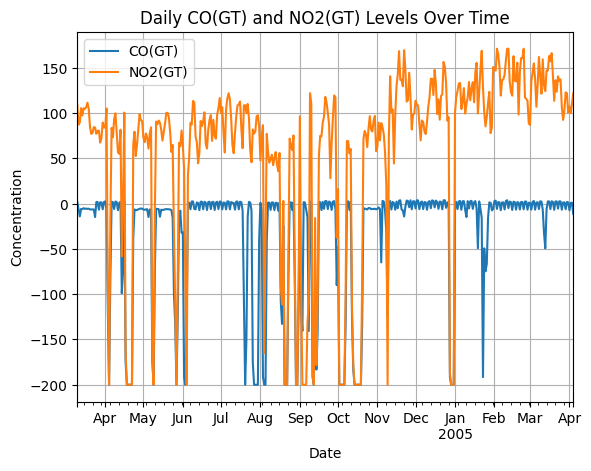

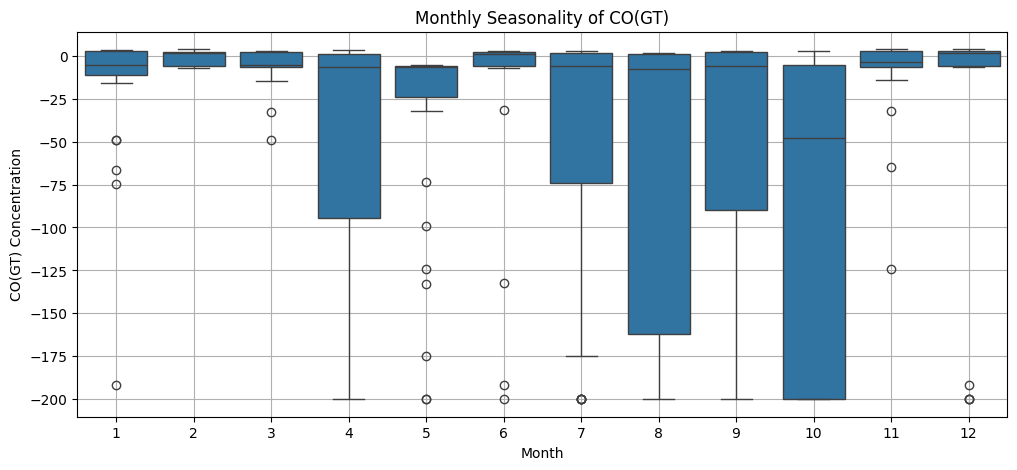

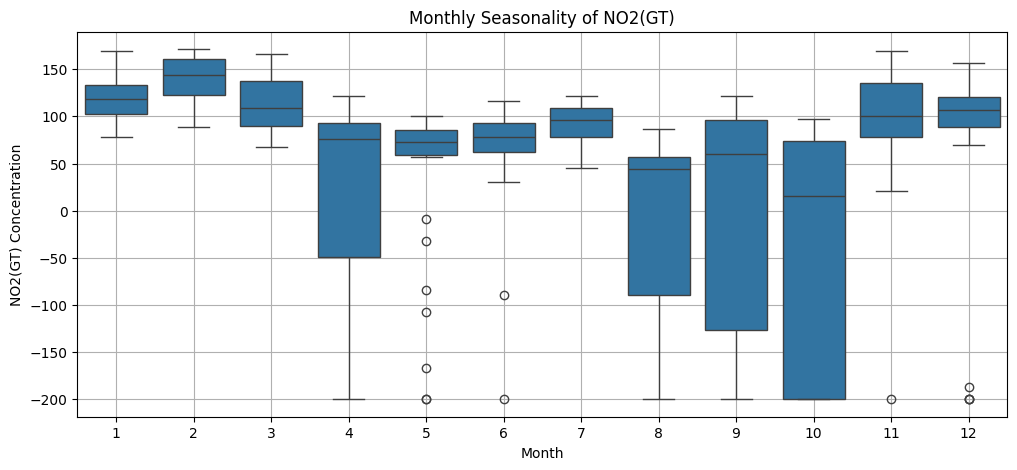

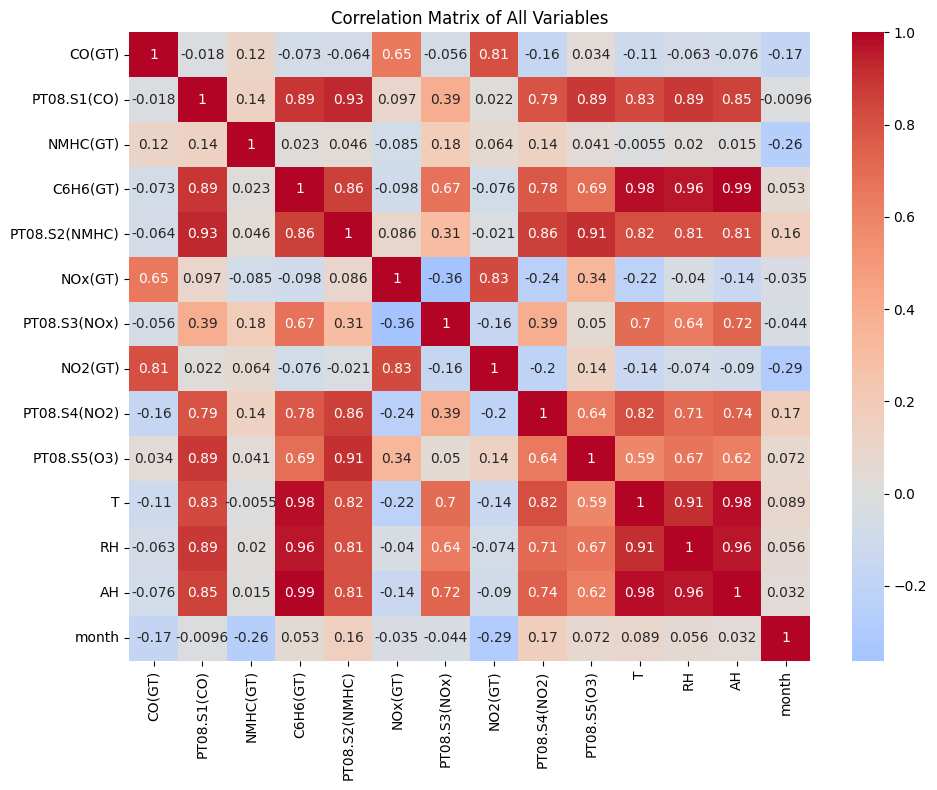

In [4]:
# --- Exploratory Data Analysis (EDA) ---
# 1. Trend Analysis: Plot daily CO(GT) and NO2(GT) levels
plt.figure(figsize=(12,6))
daily_df[['CO(GT)', 'NO2(GT)']].plot()
plt.title('Daily CO(GT) and NO2(GT) Levels Over Time')
plt.ylabel('Concentration')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

# 2. Seasonality: Boxplot by month to visualize seasonal patterns
# Add month column for seasonal analysis
daily_df['month'] = daily_df.index.month

plt.figure(figsize=(12,5))
sns.boxplot(x='month', y='CO(GT)', data=daily_df)
plt.title('Monthly Seasonality of CO(GT)')
plt.xlabel('Month')
plt.ylabel('CO(GT) Concentration')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x='month', y='NO2(GT)', data=daily_df)
plt.title('Monthly Seasonality of NO2(GT)')
plt.xlabel('Month')
plt.ylabel('NO2(GT) Concentration')
plt.grid(True)
plt.show()

# 3. Correlation Analysis: Heatmap of correlations
plt.figure(figsize=(10,8))
sns.heatmap(daily_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of All Variables')
plt.tight_layout()
plt.show()


### 3. Feature Engineering
- Create lag features for `CO(GT)` and `NO₂(GT)` to incorporate historical values.
- Add time-based features (e.g., hour of the day, day of the week, month).
- Include environmental factors (`T`, `RH`, `AH`) as predictors.


In [5]:
# --- Feature Engineering ---
# 1. Create lag features for CO(GT) and NO2(GT) to capture temporal dependencies
for col in ['CO(GT)', 'NO2(GT)']:
    daily_df[f'{col}_lag1'] = daily_df[col].shift(1)  # 1-day lag
    daily_df[f'{col}_lag2'] = daily_df[col].shift(2)  # 2-day lag
    daily_df[f'{col}_lag3'] = daily_df[col].shift(3)  # 3-day lag

In [6]:
# 2. Add time-based features
daily_df['day_of_week'] = daily_df.index.dayofweek  # Monday=0, Sunday=6
daily_df['day_of_month'] = daily_df.index.day       # Day of month (1-31)
daily_df['is_weekend'] = daily_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # Weekend flag

feature_cols = ['CO(GT)', 'NO2(GT)', 'CO(GT)_lag1', 'CO(GT)_lag2', 'CO(GT)_lag3',
                'NO2(GT)_lag1', 'NO2(GT)_lag2', 'NO2(GT)_lag3',
                'day_of_week', 'day_of_month', 'is_weekend', 'month']

In [7]:
# 4. Include environmental predictors if available
for col in ['T', 'RH', 'AH']:
    if col in daily_df.columns:
        feature_cols.append(col)

# Drop rows with NaN values due to lagging
daily_df = daily_df.dropna()

# Preview engineered features
print("Engineered Features (First 5 rows):")
print(daily_df[feature_cols].head())

Engineered Features (First 5 rows):
              CO(GT)     NO2(GT)  CO(GT)_lag1  CO(GT)_lag2  CO(GT)_lag3  \
datetime                                                                  
2004-03-13 -5.750000  105.583333   -14.095833    -6.187500     1.966667   
2004-03-14 -5.966667   97.458333    -5.750000   -14.095833    -6.187500   
2004-03-15 -4.975000  105.458333    -5.966667    -5.750000   -14.095833   
2004-03-16 -5.679167  104.916667    -4.975000    -5.966667    -5.750000   
2004-03-17 -5.387500  106.625000    -5.679167    -4.975000    -5.966667   

            NO2(GT)_lag1  NO2(GT)_lag2  NO2(GT)_lag3  day_of_week  \
datetime                                                            
2004-03-13     89.916667     87.375000    108.833333            5   
2004-03-14    105.583333     89.916667     87.375000            6   
2004-03-15     97.458333    105.583333     89.916667            0   
2004-03-16    105.458333     97.458333    105.583333            1   
2004-03-17    104.916667

### 4. Time-Series Forecasting
- Train separate models for **CO(GT)** and **NO₂(GT)**.
- Explore the following forecasting approaches:
  - **Statistical Models**:
    - Classical models like ARIMA or SARIMA for univariate forecasting.
  - **Machine Learning Models**:
    - Use regression models trained on lag features and external predictors.
  - **Deep Learning Models**:
    - Apply LSTM, GRU, or other RNN-based models for sequence forecasting.
- Evaluate and compare the models.


In [8]:
# --- Time-Series Forecasting ---
# We'll demonstrate two approaches: ARIMA (statistical) and RandomForestRegressor (machine learning)

# 1. ARIMA for CO(GT) (univariate forecasting)
# Split into train/test sets (80/20 split)
co_series = daily_df['CO(GT)']
train_size = int(len(co_series) * 0.8)
co_train, co_test = co_series[:train_size], co_series[train_size:]

# Fit ARIMA model with order (3,1,2) - can be optimized through parameter tuning
arima_co = ARIMA(co_train, order=(3,1,2))
co_model = arima_co.fit()
co_pred = co_model.forecast(steps=len(co_test))

# 2. RandomForestRegressor for NO2(GT) (multivariate forecasting)
# Prepare features and target variable
X = daily_df[feature_cols].drop(['NO2(GT)'], axis=1)  # All features except target
y = daily_df['NO2(GT)']  # Target variable

# Split into train/test sets (80/20 split) without shuffling to preserve time order
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Initialize and train Random Forest model
rf_no2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_no2.fit(X_train, y_train)
no2_pred = rf_no2.predict(X_test)

# Save actual values for evaluation
co_actual = co_test
no2_actual = y_test

### 5. Model Evaluation
- Use appropriate metrics for forecasting:
  - Mean Absolute Error (MAE)
  - Root Mean Squared Error (RMSE)
  - Mean Absolute Percentage Error (MAPE)
- Plot actual vs. predicted values to visualize performance.


CO(GT) ARIMA Model Performance:
MAE: 38.10, RMSE: 41.17, MAPE: 1494.44%


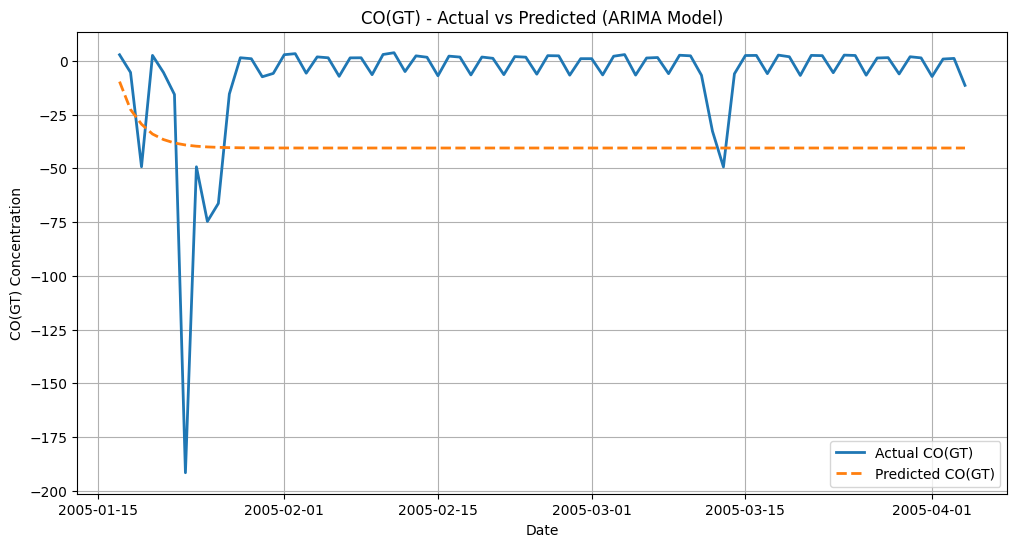


NO2(GT) Random Forest Model Performance:
MAE: 23.46, RMSE: 36.38, MAPE: 18.06%


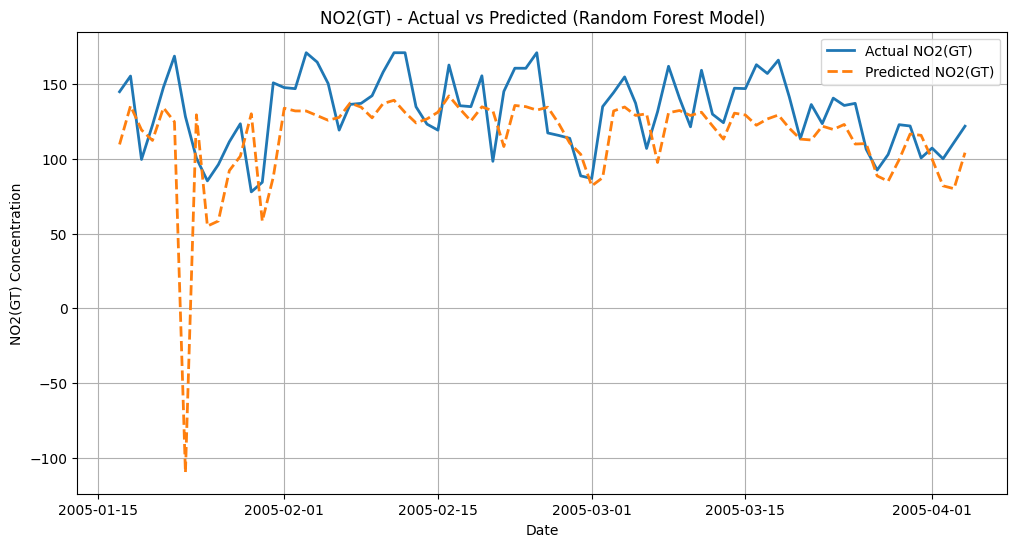

In [9]:
# --- Model Evaluation ---
# Define evaluation metrics including MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# CO(GT) ARIMA evaluation
mae_co = mean_absolute_error(co_actual, co_pred)
rmse_co = np.sqrt(mean_squared_error(co_actual, co_pred))
mape_co = mape(co_actual, co_pred)

print(f'CO(GT) ARIMA Model Performance:')
print(f'MAE: {mae_co:.2f}, RMSE: {rmse_co:.2f}, MAPE: {mape_co:.2f}%')

# Plot actual vs predicted values for CO(GT)
plt.figure(figsize=(12,6))
plt.plot(co_actual.index, co_actual, label='Actual CO(GT)', linewidth=2)
plt.plot(co_actual.index, co_pred, label='Predicted CO(GT)', linestyle='--', linewidth=2)
plt.title('CO(GT) - Actual vs Predicted (ARIMA Model)')
plt.ylabel('CO(GT) Concentration')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

# NO2(GT) RandomForest evaluation
mae_no2 = mean_absolute_error(no2_actual, no2_pred)
rmse_no2 = np.sqrt(mean_squared_error(no2_actual, no2_pred))
mape_no2 = mape(no2_actual, no2_pred)

print(f'\nNO2(GT) Random Forest Model Performance:')
print(f'MAE: {mae_no2:.2f}, RMSE: {rmse_no2:.2f}, MAPE: {mape_no2:.2f}%')

# Plot actual vs predicted values for NO2(GT)
plt.figure(figsize=(12,6))
plt.plot(no2_actual.index, no2_actual, label='Actual NO2(GT)', linewidth=2)
plt.plot(no2_actual.index, no2_pred, label='Predicted NO2(GT)', linestyle='--', linewidth=2)
plt.title('NO2(GT) - Actual vs Predicted (Random Forest Model)')
plt.ylabel('NO2(GT) Concentration')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

### 6. Visualization and Insights
- Generate forecasts for future dates and visualize the trends.
- Highlight seasonal patterns, peak times, and periods of concern.
- Provide actionable recommendations based on predicted trends.



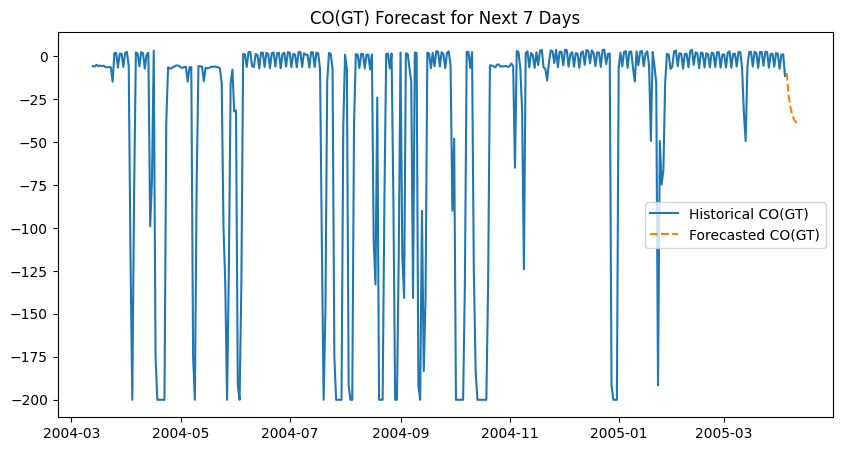

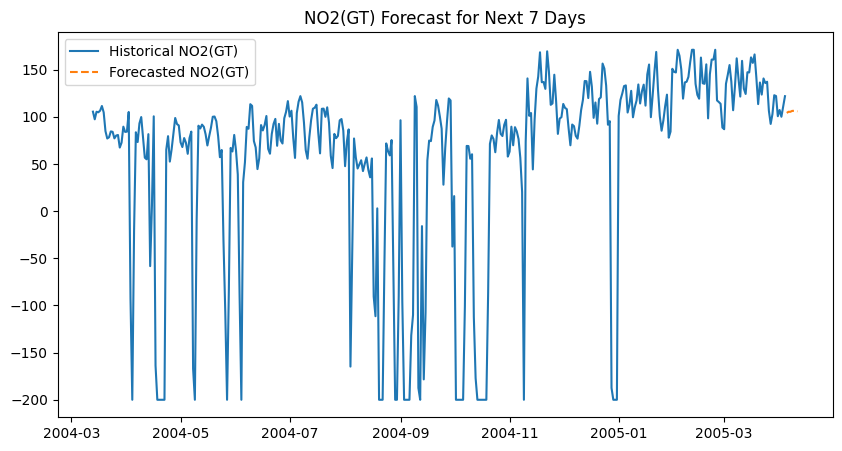


--- Insights & Recommendations ---
CO(GT) levels are within safe limits for the next week.


In [10]:
# --- Visualization and Insights ---
# Forecast future values and visualize trends

# 1. Forecast next 7 days for CO(GT) using ARIMA
future_steps = 7
co_forecast = co_model.forecast(steps=future_steps)
future_dates = pd.date_range(start=co_actual.index[-1] + pd.Timedelta(days=1), periods=future_steps)

plt.figure(figsize=(10,5))
plt.plot(co_series.index, co_series, label='Historical CO(GT)')
plt.plot(future_dates, co_forecast, label='Forecasted CO(GT)', linestyle='--')
plt.title('CO(GT) Forecast for Next 7 Days')
plt.legend()
plt.show()

# 2. Forecast next 7 days for NO2(GT) using RandomForest (simple approach)
# Use last available feature row for prediction
last_features = daily_df[feature_cols].iloc[-1]
no2_forecast = []
current_features = last_features.copy()
for i in range(future_steps):
    pred = rf_no2.predict([current_features.drop('NO2(GT)')])[0]
    no2_forecast.append(pred)
    # Update lag features for next prediction
    current_features['NO2(GT)_lag3'] = current_features['NO2(GT)_lag2']
    current_features['NO2(GT)_lag2'] = current_features['NO2(GT)_lag1']
    current_features['NO2(GT)_lag1'] = pred
    current_features['NO2(GT)'] = pred
future_dates_no2 = pd.date_range(start=no2_actual.index[-1] + pd.Timedelta(days=1), periods=future_steps)

plt.figure(figsize=(10,5))
plt.plot(y.index, y, label='Historical NO2(GT)')
plt.plot(future_dates_no2, no2_forecast, label='Forecasted NO2(GT)', linestyle='--')
plt.title('NO2(GT) Forecast for Next 7 Days')
plt.legend()
plt.show()

# 3. Insights and Recommendations
print("\n--- Insights & Recommendations ---")
if max(co_forecast) > 2:
    print("Warning: Forecasted CO(GT) levels exceed safe limits. Consider traffic restrictions and public advisories.")
else:
    print("CO(GT) levels are within safe limits for the next week.")
if max(no2_forecast) > 50:
    print("Warning: Forecasted NO2(GT) levels are high. Recommend monitoring industrial emissions and promoting green transport.")
else:
    print("NO2(GT) levels are within safe limits for the next week.")